<a href="https://colab.research.google.com/github/rkurniawati/CDER-notebooks/blob/main/Introduction_to_OpenMP_with_Python_and_OpenMPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to OpenMP with Python

In this notebook, you will find examples of Python code with OpenMP directives. The support for OpenMP directives is done using a pre-processory provided in the OpenMPy package developed by Tennessee Tech. 

Below we will first download the package, unzip it, and setup the jython script environment. 

In [ ]:
!wget https://www.csc.tntech.edu/pdcincs/resources/modules/tools/updated/OpenMPy.zip
!unzip -q OpenMPy.zip
!chmod +x OpenMPy/bin/jython 
!pip3 install -r OpenMPy/requirements.txt

--2021-08-13 19:16:44--  https://www.csc.tntech.edu/pdcincs/resources/modules/tools/updated/OpenMPy.zip
Resolving www.csc.tntech.edu (www.csc.tntech.edu)... 149.149.134.5
Connecting to www.csc.tntech.edu (www.csc.tntech.edu)|149.149.134.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65724940 (63M) [application/zip]
Saving to: ‘OpenMPy.zip.1’

OpenMPy.zip.1       100%[===================>]  62.68M  19.2MB/s    in 3.9s    

2021-08-13 19:16:48 (15.9 MB/s) - ‘OpenMPy.zip.1’ saved [65724940/65724940]



# Hello World!

Below is a Hello World program, OpenMPy style.

In [ ]:
%%writefile helloWorld.py
from omp import *
import sys

num_threads = int(sys.argv[1])

#omp parallel num_threads(num_threads)
    myID = omp_get_thread_num()
    tCount = omp_get_num_threads()
    #omp critical
        print("Hello from : ", myID, " of ", tCount)

Writing helloWorld.py


In [ ]:
!JYTHON_HOME=./OpenMPy  OpenMPy/bin/jython helloWorld.py 4

Hello from :  0  of  4
Hello from :  1  of  4
Hello from :  3  of  4
Hello from :  2  of  4


# How OpenMPy works

Standard Python interpreter has a GIL (Global Interpreter Lock), which causes threads to run serially. To workaound this issue, OpenMPy has a modified Jython intepreter which will first pre-process the Python code before executing it. 



Script execution in OpenMPy:

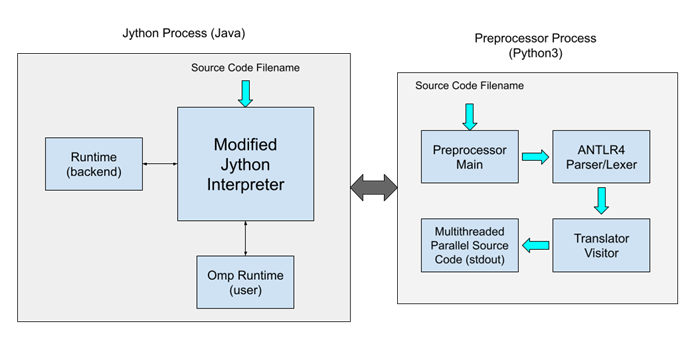

Limitations:
 - Jython is basically an implementation of Python 2.7 interpreter. 
 - In Jython/OpenMPy, you have to use jarray since Python's arrays are synchronized (any code that touches the a list or array will be serialized). 
 - Can't use Python modules written in C in Jython
 - Current OpenMPy implementation is slower than C - the amount of speed up you get may not be as expected. 


Notes:
- After every `#omp` directive, the code block following the directive has to be indented (see examples below)
- In Jython, if you see `no viable alternative at input '<EOF>'`, add a new line at the end of file.

Supported directives:
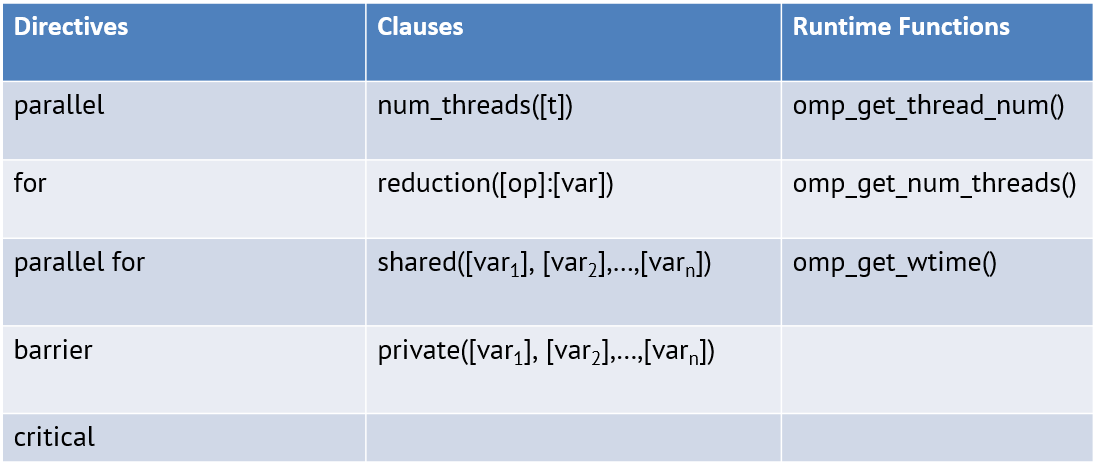

# Parallel sum

Below you will see an example of computing sum of an array in parallel using the `omp reduction` clause. 

In [ ]:
%%writefile parallelsum.py
from omp import *
import sys
import random
import math
from jarray import zeros, array

def fillArray(a):
  ran = random.Random()
  for i in range(len(a)):
    a[i] = ran.uniform(0,100)

numThreads = 0
n = 0

if len(sys.argv) != 3:
  print("usage: ", sys.argv[0], " <num_threads> <num_items>")
  sys.exit(1)

numThreads = int(sys.argv[1])
n = int(sys.argv[2])

a = zeros(n, float)
fillArray(a)

sum = 0

#omp parallel for shared(a) num_threads(numThreads) reduction(+:sum)
  for i in range(len(a)):
    sum += a[i]

print("Sum is ", sum)




Overwriting parallelsum.py


In [ ]:
!time JYTHON_HOME=./OpenMPy OpenMPy/bin/jython parallelsum.py 1 1000

Sum is  49985.8602826

real	0m5.533s
user	0m9.096s
sys	0m0.406s


In [ ]:
!time JYTHON_HOME=./OpenMPy OpenMPy/bin/jython parallelsum.py 4 1000

Sum is  49113.9633377

real	0m5.533s
user	0m9.259s
sys	0m0.380s


## Count Primes

In [ ]:
%%writefile countPrimes.py
from omp import *
import sys
import random
import math
from jarray import array, zeros
        
def fillArray(a):
    ran = random.Random(123) # use a fixed seed, eg 123
    for i in  range(len(a)):
        a[i] = ran.randint(0,10000)

def isPrime(num):
    if num == 2: return True

    for i in range(3, int(math.sqrt(num))):
        if (num % i) == 0:
            return False;

    return True;

numThreads = 0
n = 0

if len(sys.argv) != 3:
    print("usage: ", sys.argv[0], " <num_threads> <num_items>")
    sys.exit(1)

try:
    numThreads = int(sys.argv[1])
    n = int(sys.argv[2])
except ValueError:
    print("Cannot convert arguments to integers")
    sys.exit(1)

a = zeros(n, int)
fillArray(a)

count = 0
		
#omp parallel for shared(a) num_threads(numThreads) reduction(+:count)
    for i in range(len(a)):
        if isPrime(a[i]):
            count += 1

print("Count is ", count)



Overwriting countPrimes.py


In [ ]:
!time JYTHON_HOME=./OpenMPy OpenMPy/bin/jython parallelsum.py 1 1000

Sum is  50917.4584328

real	0m5.825s
user	0m9.686s
sys	0m0.453s


In [ ]:
!time JYTHON_HOME=./OpenMPy OpenMPy/bin/jython parallelsum.py 2 1000

Sum is  50697.3759326

real	0m5.681s
user	0m9.596s
sys	0m0.390s


# Calculating Pi using the Monte Carlo method

In [ ]:
%%writefile monteCarlo.py
from omp import *
import sys
import random
import math

numIters = 0

if len(sys.argv) != 3:
    print("usage: ", sys.argv[0], " <num_threads> <num_iterations>")
    sys.exit(1)

try:
    numThreads = int(sys.argv[1])
    numIters = int(sys.argv[2])
except ValueError:
    print("Cannot convert argument to integer")
    sys.exit(1)

numIn = 0
numOut = 0

#omp parallel num_threads(numThreads) reduction(+:numIn) reduction(+:numOut)
    localRandom = random.Random()
    # print("Number of threads ",omp_get_num_threads())
    myIters = numIters
    numIn = 0
    numOut = 0
    #omp for
        for i in range(myIters):
            #get random number from 0 to 1
            x = localRandom.uniform(0,1)
            y = localRandom.uniform(0,1)
            hyp = x*x + y*y # don't need sqrt here since sqrt(1.0) is 1.0
            if hyp < 1.0:
                numIn += 1
            else:
                numOut += 1

p = float(numIn)/(numIn+numOut)
fourp = 4*p
print("Pi is ", fourp)



Overwriting monteCarlo.py


In [ ]:
!time JYTHON_HOME=./OpenMPy OpenMPy/bin/jython monteCarlo.py 1 10000000

Pi is  3.141432

real	0m20.749s
user	0m36.924s
sys	0m0.731s


In [ ]:
!time JYTHON_HOME=./OpenMPy OpenMPy/bin/jython monteCarlo.py 4 10000000

Pi is  3.1417268

real	0m20.245s
user	0m37.054s
sys	0m0.769s
